In [3]:
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split, cross_validate
from surprise import Dataset, Reader, SVD, accuracy
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, precision_score, recall_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

In [4]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [5]:
from surprise import Dataset
# 加载数据到surprise库
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

In [6]:
# 划分训练集和测试集
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
# 使用SVD算法
algo = SVD()
# 训练模型
algo.fit(trainset)
# 在测试集上进行预测
predictions = algo.test(testset)

In [7]:
# 提取真实评分和预测评分
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]
# 转换为二分类问题，假设评分大于等于4为正类，其余为负类
y_true_binary = np.array([1 if x >= 3.5 else 0 for x in y_true])
y_pred_binary = np.array([1 if x >= 3.5 else 0 for x in y_pred])

In [8]:
# 将电影ID设置为索引以便快速查找
movies.set_index('MovieID', inplace=True)

Accuracy: 0.7375201207746374
Precision: 0.7655491427601426
Recall: 0.7837696926512631
RMSE: 0.8749


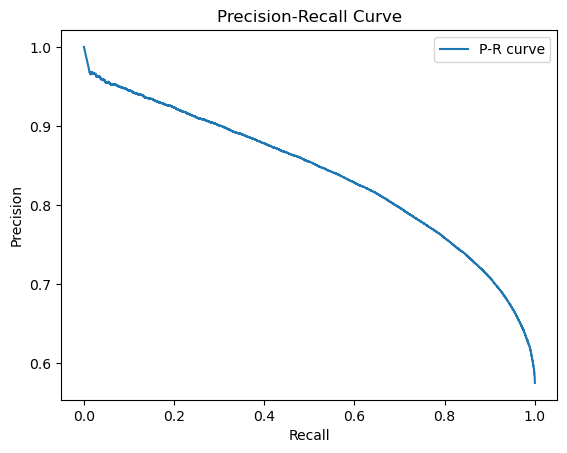

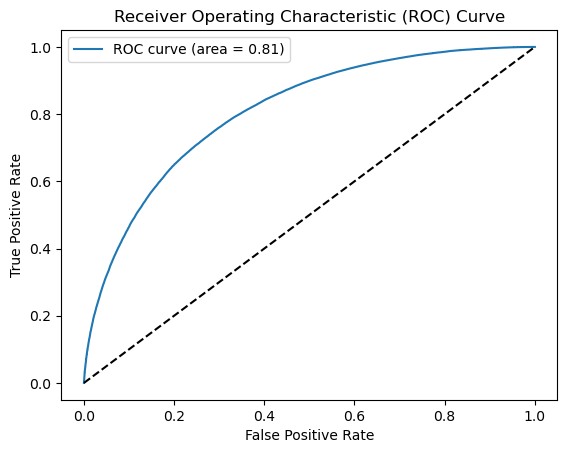

In [9]:
# 计算准确率、精确率、召回率
accuracy_score = np.mean(y_true_binary == y_pred_binary)
precision = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_pred_binary == 1)
recall = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_true_binary == 1)
print(f'Accuracy: {accuracy_score}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
# 计算RMSE
rmse = accuracy.rmse(predictions)
# 计算P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true_binary, y_pred)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)
# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [10]:
# 给特定用户推荐N个电影，并显示电影的名字和类型
def get_top_n_recommendations(user_id, n=10):
    # 获取用户已经评分的电影
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_rated_items = set(user_ratings['MovieID'])
    # 获取所有电影的ID
    all_items = set(ratings['MovieID'])
    # 未评分的电影
    items_to_predict = all_items - user_rated_items
    # 预测未评分电影的评分
    predictions = [algo.predict(user_id, item_id) for item_id in items_to_predict]
    # 按预测评分排序
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)
    # 返回前N个推荐
    top_n_recommendations = recommendations[:n]
    # 获取推荐电影的名字和类型
    results = []
    for pred in top_n_recommendations:
        movie_id = pred.iid
        movie_title = movies.loc[movie_id]['Title']
        movie_genres = movies.loc[movie_id]['Genres']
        results.append((movie_id, movie_title, movie_genres, pred.est))
    return results
# 示例：为用户ID为1的用户推荐10部电影
user_id = 1
recommendations = get_top_n_recommendations(user_id, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")

Top 10 recommendations for user ID 1:
Movie ID: 318, Title: Shawshank Redemption, The (1994), Genres: Drama, Predicted Rating: 4.9430862644407405
Movie ID: 953, Title: It's a Wonderful Life (1946), Genres: Drama, Predicted Rating: 4.8561509683893656
Movie ID: 1307, Title: When Harry Met Sally... (1989), Genres: Comedy|Romance, Predicted Rating: 4.795449737283171
Movie ID: 910, Title: Some Like It Hot (1959), Genres: Comedy|Crime, Predicted Rating: 4.7524809040884275
Movie ID: 3022, Title: General, The (1927), Genres: Comedy, Predicted Rating: 4.73122899457959
Movie ID: 1231, Title: Right Stuff, The (1983), Genres: Drama, Predicted Rating: 4.711560881245844
Movie ID: 669, Title: Aparajito (1956), Genres: Drama, Predicted Rating: 4.709114799025158
Movie ID: 3469, Title: Inherit the Wind (1960), Genres: Drama, Predicted Rating: 4.702405670170463
Movie ID: 916, Title: Roman Holiday (1953), Genres: Comedy|Romance, Predicted Rating: 4.701902903888364
Movie ID: 1148, Title: Wrong Trousers, Th

In [26]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [27]:
from lightfm.data import Dataset
from lightfm import LightFM
# 过滤出评分大于等于4的记录，视为正反馈
ratings = ratings[ratings['Rating'] >= 4]

# 将用户和电影的特征转化为字符串格式
users['Age'] = users['Age'].astype(str)
users['Occupation'] = users['Occupation'].astype(str)
users['Zip-code'] = users['Zip-code'].astype(str)

# 将电影类型进行分割
movies['Genres'] = movies['Genres'].apply(lambda x: x.split('|'))

# 定义lightfm数据集
dataset = Dataset()

# 构建数据集
dataset.fit(users['UserID'], movies['MovieID'],
            user_features=users[['Gender', 'Age', 'Occupation', 'Zip-code']].apply(lambda x: ' '.join(x), axis=1),
            item_features=movies['Genres'].apply(lambda x: ' '.join(x)))
# 构建交互矩阵
(interactions, weights) = dataset.build_interactions([(x['UserID'], x['MovieID']) for _, x in ratings.iterrows()])
# 构建用户特征矩阵
user_features = dataset.build_user_features([(x['UserID'], ' '.join([str(x['Gender']), str(x['Age']), str(x['Occupation']), str(x['Zip-code'])])) for _, x in users.iterrows()])
# 构建电影特征矩阵
item_features = dataset.build_item_features([(x['MovieID'], ' '.join(x['Genres'])) for _, x in movies.iterrows()])


KeyError: ('MovieID', 'Genres')

In [ ]:
# 训练模型
model = LightFM(loss='warp')
model.fit(interactions, sample_weight=weights, user_features=user_features, item_features=item_features, epochs=30, num_threads=2)

# 预测评分
user_ids, item_ids = interactions.nonzero()
y_true = weights.toarray()[user_ids, item_ids]
y_pred = model.predict(user_ids, item_ids, user_features=user_features, item_features=item_features)

In [ ]:
# 计算RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

# 计算评估指标
train_precision = precision_at_k(model, interactions, k=10, user_features=user_features, item_features=item_features).mean()
train_recall = recall_at_k(model, interactions, k=10, user_features=user_features, item_features=item_features).mean()
train_auc = auc_score(model, interactions, user_features=user_features, item_features=item_features).mean()

print(f'Training Precision: {train_precision}')
print(f'Training Recall: {train_recall}')
print(f'Training AUC: {train_auc}')

# 计算P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# 推荐电影函数
def recommend_movies(model, user_id, user_features, item_features, movies_df, n=10):
    scores = model.predict(user_id, np.arange(movies_df.shape[0]), user_features=user_features, item_features=item_features)
    top_items = np.argsort(-scores)[:n]
    recommended_movies = []
    for item_id in top_items:
        movie_id = movies_df.iloc[item_id]['movie_id']
        title = movies_df.iloc[item_id]['title']
        genres = movies_df.iloc[item_id]['genres']
        predicted_rating = scores[item_id]
        recommended_movies.append((movie_id, title, genres, predicted_rating))
    return recommended_movies

# 示例：为用户ID为1的用户推荐10部电影
user_id = 1
recommendations = recommend_movies(model, user_id, user_features, item_features, movies_df, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")